# Decision Tree Classification

<p>The following notebook provides an example code of predicting whether <b>the client will subscribe to a term deposit or not </b> using Decision Tree classification.
The dependent variable is <b>Y (subscribing the term deposit) (1-"Yes", 0-"No")</b>. 
    
<br>The general sequence of steps for the analysis the following:
1. [Descriptive analysis](#pandas)
2. [Fully grown Decision Tree (w/o GridSearchCV)](#stats)
3. [Manually trying different parameters for Decision Tree Classification](#manual)
4. [Tuned Decision Tree using GridSearch](#stats1)
5. [Decision Tree and Logistic Regression results comparison based on non-scaled data](#stats2)
6. [Decision Tree and Logistic Regression results comparison based on scaled data](#stats3)
7. [Gain and Lift charts for winning DT model](#stats4)

 <h2>1.Descriptive analysis</h2> <a name="pandas"></a>

The initial data consists of 4119 observations of 21 variables. There are no duplicates, missing values and variables with single value for all observations.
As the main model to be used is a non-parametric one(Decision Tree), we are not going to dive deep into the correlations and
data manipulation as we used to do. The only transformation to be done will be data scaling, which will be done using a sklearn method(not manually).
Deposit subscription is not evenly balanced between 0s and 1s. As the countplot and value counts show, only about 11% of employees are subscribing and ~89% are not.So we can use this info as a naive assumption for newcomers to decide whether they'll leave or stay. In other words, if the resulting score is more than the noted value, then our model will be not bad, otherwise-a bad one. 

In [2]:
#data manipulation and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

#libraries for modelling and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,classification_report,roc_auc_score,roc_curve
import scikitplot as skplt #in case of error run <<!pip install scikit-plot>> and run the code again
#for not showing warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
#importing the data and making a dataframe
data=pd.read_excel("bank.xlsx", sheet_name="bank")

In [4]:
#data overview
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
age               4119 non-null int64
job               4119 non-null object
marital           4119 non-null object
education         4119 non-null object
default           4119 non-null object
housing           4119 non-null object
loan              4119 non-null object
contact           4119 non-null object
month             4119 non-null object
day_of_week       4119 non-null object
duration          4119 non-null int64
campaign          4119 non-null int64
pdays             4119 non-null int64
previous          4119 non-null int64
poutcome          4119 non-null object
emp_var_rate      4119 non-null float64
cons_price_idx    4119 non-null float64
cons_conf_idx     4119 non-null float64
euribor3m         4119 non-null float64
nr_employed       4119 non-null float64
y                 4119 non-null int64
dtypes: float64(5), int64(6), object(10)
memory usage: 675.9+ KB


In [5]:
#have a look at first rows of the dataframe
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,30,blue_collar,married,basic_9y,no,yes,no,cellular,may,fri,...,2,0,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high_school,no,no,no,telephone,may,fri,...,4,0,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high_school,no,yes,no,telephone,jun,wed,...,1,0,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic_9y,no,unknown,unknown,telephone,jun,fri,...,3,0,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin_,married,university_degree,no,yes,no,cellular,nov,mon,...,1,0,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


In [6]:
data.describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,0.227725,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695,0.109493
std,10.313362,254.703736,2.568159,1.369053,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904,0.312294
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000,0.000000
25%,32.000000,103.000000,1.000000,0.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000,0.000000
50%,38.000000,181.000000,2.000000,0.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.000000,317.000000,3.000000,0.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,88.000000,3643.000000,35.000000,21.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [7]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:", data.duplicated().sum())
print("Missing values:", data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 0
Missing values: 0
Single valued columns: Index([], dtype='object')


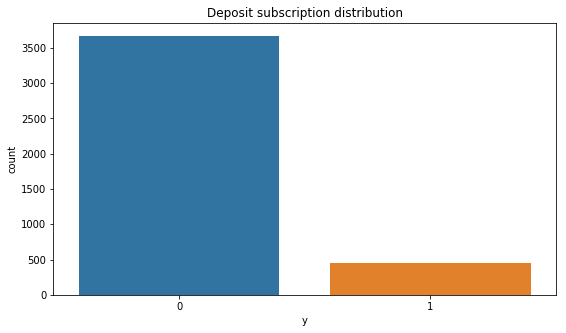

In [8]:
#let's visualise the distribution of y
plt.figure(figsize=(9,5))
sns.countplot(data.y)
plt.title("Deposit subscription distribution")
plt.show()

In [9]:
#lets count the benchmark for deposit subscription distribution
data.y.value_counts(normalize=True).mul(100).rename("Deposit subscription distribution")

0    89.05074
1    10.94926
Name: Deposit subscription distribution, dtype: float64

 <h2>2.Fully grown Decision Tree (w/o GridSearchCV)</h2> <a name="stats"></a>

We decided first to run model on not scaled data and without removing any variable to see its performance. On the fully grown DT we got 1 and 0.73 ROC AUC scores on train and test sets, respectively. This means that our model is overfitting. Therefore,
the next step would be hyperparameter tuning (simplifying the tree by pruning
peripheral branches to avoid overfitting).

In [10]:
#making dummes,train test split
data=pd.get_dummies(data, drop_first=True)

In [11]:
#separating X and Y
Y=data["y"]
X=data.drop("y",axis=1)

In [12]:
#splitting the data into train and test sets
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.25, random_state=42)

In [13]:
#building the model
dt=DecisionTreeClassifier(random_state=42)
dt.fit(X0,Y0)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [14]:
#calculating probabilities
Y0_dt=dt.predict_proba(X0)[:,1]
Y1_dt=dt.predict_proba(X1)[:,1]

In [15]:
#calculating roc auc score
print("ROC_AUC Train for Fully grown DT:",roc_auc_score(Y0,Y0_dt).round(2))
print("ROC_AUC Test for Fully grown DT:",roc_auc_score(Y1,Y1_dt).round(2))

ROC_AUC Train for Fully grown DT: 1.0
ROC_AUC Test for Fully grown DT: 0.73


## 2.1 Manually trying different parameters for Decision Tree Classification <a name="manual"></a>

Manual tuning or just setting up <code>max_depth</code> and <code>min_samples_leaf</code> in the estimator to some values gives a much 
better result than in case of fully grown tree.

In [16]:
#setting 2 hyperparameter values manually
dt1=DecisionTreeClassifier(random_state=42, max_depth=10,min_samples_leaf=200).fit(X0,Y0)

In [17]:
#much higher ROC AUC score and almost no overfitting
print("ROC_AUC Train for Manually Tuned DT:",roc_auc_score(Y0,dt1.predict_proba(X0)[:,1]).round(2))
print("ROC_AUC Test for Manually Tuned DT:",roc_auc_score(Y1,dt1.predict_proba(X1)[:,1]).round(2))

ROC_AUC Train for Manually Tuned DT: 0.93
ROC_AUC Test for Manually Tuned DT: 0.91


 <h2>3.Tuned Decision Tree using GridSearch</h2> <a name="stats1"></a>

In order to fight overfitting, we will use GridSearch to tune the hyperparameters of the model. In particular, the ones we will
control are the following:
  - <code>max_depth</code>: None or integer. The maximum depth of the tree. If None, then nodes are expanded until
       all leaves are pure or until all leaves contain less than min_samples_split samples.
  - <code>min_samples_split</code>:integer or float. The minimum number of samples required to split an internal node.If integer, then it is considered as the minimum number. If float, then this is a  fraction and (min_samples_split * n_samples) are the minimum number of samples for each split.
  - <code>class_weight</code>: "balanced" or None. The "balanced" mode uses the values of y to automatically adjust
    weights inversely proportional to class frequencies in the input data as ``n_samples / (n_classes * np.bincount(y))``
 
We tuned hyperparameters on training set and used the best parameters to build another DT model. This tuned model produced 0.87 and 0.83 ROC AUC scores on training and testing sets, respectively, dramatically decreasing the overfitting from the previous result.

    

In [18]:
#setting up the ranges for hyperparameters
param_dt={"max_depth":range(1,15),"min_samples_leaf":range(10,150,10),
          "class_weight":["balanced", None]}

In [19]:
#Cross-Validated Gridsearch using parameters
gs_dt=GridSearchCV(estimator=dt,param_grid=param_dt,scoring="roc_auc",cv=5)
gs_dt.fit(X0,Y0)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(1, 15), 'min_samples_leaf': range(10, 150, 10), 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [20]:
#let's see the optimal parameters
gs_dt.best_params_

{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 30}

In [21]:
#fitting the model with best parameters
dt_grid=DecisionTreeClassifier(class_weight="balanced",max_depth=5,
                             min_samples_leaf=30, random_state=42).fit(X0,Y0)

#probabilities
Y0_dt_grid=dt_grid.predict_proba(X0)[:,1]
Y1_dt_grid=dt_grid.predict_proba(X1)[:,1]


In [22]:
#calculating roc auc score 
print("ROC_AUC Train for Tuned DT:",roc_auc_score(Y0,Y0_dt_grid).round(2))
print("ROC_AUC Test for Tuned DT:",roc_auc_score(Y1,Y1_dt_grid).round(2))

ROC_AUC Train for Tuned DT: 0.95
ROC_AUC Test for Tuned DT: 0.92


In [23]:
#Mean cross val score for model with default hyperparameters
print("Mean 5-fold ROC AUC score for DT Tuned hyperparameters:",np.mean(cross_val_score(estimator=dt_grid, X=X,y=Y,cv=5, scoring="roc_auc")).round(2))

Mean 5-fold ROC AUC score for DT Tuned hyperparameters: 0.92


 <h2>4.Decision Tree and Logistic Regression results comparison based on non-scaled data</h2> <a name="stats2"></a>

We will fit Logistic regression based on the best parameters obtained from the Grid Search. As the roc_auc scores show, logistic regression results based on single split are better than DT's. Here, tuned logit gets 0.95 and 0.93 ROC AUC scores on training and testing sets, respectively, outperforming DT on testing set. Logit also performs better in terms of 5-fold CV score:while for 
tuned DT it was 0.92, Logit's is 0.93.

In [24]:
#Hyperparameter tuning for Logistic Regression
logit=LogisticRegression(random_state=42)
param_logit={'class_weight':[None,'balanced'],
            'C':np.linspace(0.0001,50,20)}
gs_logit=GridSearchCV(estimator=logit,param_grid=param_logit,
                        scoring="roc_auc",
                        cv=5,verbose=1).fit(X0,Y0)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    7.9s finished


In [25]:
gs_logit.best_params_

{'C': 2.631673684210526, 'class_weight': 'balanced'}

In [26]:
logit_grid=LogisticRegression(C=2.631673684210526, class_weight='balanced',random_state=42).fit(X0,Y0)
#making predictions
Y0_logit=logit_grid.predict_proba(X0)[:,1]
Y1_logit=logit_grid.predict_proba(X1)[:,1]

In [27]:
#calculating roc auc score 
print("ROC_AUC Train:",roc_auc_score(Y0,Y0_logit).round(2))
print("ROC_AUC Test:",roc_auc_score(Y1,Y1_logit).round(2))

ROC_AUC Train: 0.95
ROC_AUC Test: 0.93


In [28]:
print("Mean 5-fold ROC AUC score for LOGIT Tuned hyperparameters:",np.mean(cross_val_score(estimator=logit_grid, X=X,y=Y,cv=5, scoring="roc_auc")).round(2))

Mean 5-fold ROC AUC score for LOGIT Tuned hyperparameters: 0.93


 <h2>5.Decision Tree and Logistic Regression results comparison based on scaled data</h2> <a name="stats3"></a>

Now let's see whether the results of Logistic Regression and Decision Tree will differ if we scale our data. For scaling, we will use Standard scaler from sklearn.It standardizes features by removing the mean and scaling to unit variance.
As we see, when Gridsearching on scaled data, best params and results have not changed for both DT and Logit.


In [29]:
#Standardization
sc=StandardScaler()
X0_sc=pd.DataFrame(sc.fit_transform(X0), columns=X0.columns.tolist())
X1_sc=pd.DataFrame(sc.fit_transform(X1), columns=X1.columns.tolist())

In [30]:
#GridSearching Logit
logit_sc=LogisticRegression(random_state=42)
param_logit_sc={'class_weight':[None,'balanced'],
            'C':np.linspace(0.0001,50,20)}
gs_logit_scaled=GridSearchCV(estimator=logit_sc,param_grid=param_logit_sc,
                        scoring="roc_auc",
                        cv=5,verbose=1).fit(X0_sc,Y0)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   11.3s finished


In [31]:
gs_logit.best_params_

{'C': 2.631673684210526, 'class_weight': 'balanced'}

In [32]:
logit_scaled=LogisticRegression(C=50, class_weight="balanced", random_state=42).fit(X0_sc,Y0)
#calculating roc auc score 
print("ROC_AUC Train for Scaled logit:",roc_auc_score(Y0,gs_logit_scaled.predict_proba(X0_sc)[:,1]).round(2))
print("ROC_AUC Test for Scaled logit:",roc_auc_score(Y1,gs_logit_scaled.predict_proba(X1_sc)[:,1]).round(2))
print("Mean 5-fold ROC AUC score for Scaled LOGIT:",np.mean(cross_val_score(estimator=logit_scaled, X=sc.fit_transform(X),y=Y,cv=5, scoring="roc_auc").round(2)))

ROC_AUC Train for Scaled logit: 0.95
ROC_AUC Test for Scaled logit: 0.92
Mean 5-fold ROC AUC score for Scaled LOGIT: 0.932


In [33]:
#DT on scaled data
#setting up the ranges
dt_sc=DecisionTreeClassifier(random_state=42)
param_dt_sc={"max_depth":range(1,15),"min_samples_leaf":range(10,150,10),
          "class_weight":["balanced", None]}
gs_dt_scaled=GridSearchCV(estimator=dt_sc,param_grid=param_dt_sc,
                        scoring="roc_auc",
                        cv=5,verbose=1).fit(X0_sc,Y0)

Fitting 5 folds for each of 392 candidates, totalling 1960 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1960 out of 1960 | elapsed:   24.8s finished


In [34]:
gs_dt_scaled.best_params_

{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 30}

In [35]:
#fitting and priting the results
dt_scaled=DecisionTreeClassifier(max_depth=5, min_samples_leaf=30,class_weight="balanced", random_state=42).fit(X0_sc,Y0)
print("ROC_AUC Train:",roc_auc_score(Y0,dt_scaled.predict_proba(X0_sc)[:,1]).round(2))
print("ROC_AUC Test:",roc_auc_score(Y1,dt_scaled.predict_proba(X1_sc)[:,1]).round(2))
print("Mean 5-fold ROC AUC score Scaled DT:",np.mean(cross_val_score(estimator=dt_scaled, X=sc.fit_transform(X),y=Y,cv=5, scoring="roc_auc")).round(2))

ROC_AUC Train: 0.95
ROC_AUC Test: 0.92
Mean 5-fold ROC AUC score Scaled DT: 0.92


<h2>RESULTS SUMMARY</h2>
<p>ROC_AUC scores of all models: DT and Logit on scaled and not scaled data</p>
As we see, DT's mean 5 fold CV score doesn't differ by scaling, but Logit's score differs marginally.(if interested, remove round(2) from print).


In [39]:
#making a dictionary of models
models={"DT Tuned Not Scaled":[dt_grid],
        "DT Tuned Scaled":[dt_scaled],
        "Logit Tuned Not Scaled":[logit_grid],
        "Logit Tuned Scaled":[logit_scaled]}

In [40]:
#appending respective roc auc scores
for name, model in models.items():
    models[name].append(np.mean(cross_val_score(estimator=model[0], X=X,y=Y,cv=5, scoring="roc_auc")))

In [41]:
#printing, showing the results.
for name, model in models.items():
    print(f"Mean 5-fold ROC AUC score for {name}:", model[1].round(2))

Mean 5-fold ROC AUC score for DT Tuned Not Scaled: 0.92
Mean 5-fold ROC AUC score for DT Tuned Scaled: 0.92
Mean 5-fold ROC AUC score for Logit Tuned Not Scaled: 0.93
Mean 5-fold ROC AUC score for Logit Tuned Scaled: 0.93


 <h2>5.Gain and Lift charts for winning DT model</h2> <a name="stats4"></a>

As there was no difference between Tuned DT with scaled and not scaled data, we will show plots for DT using model for not scaled data.

In [42]:
#Summarizing the results based on CV score: CV for not scaled , tuned DT and Logit and scaled ones.
#To plot ROC curve, we should get TPR(sensitivity), FPR(1-Specificity) for different thresholds
FPR,TPR,thresholds=roc_curve(Y1,dt_grid.predict_proba(X1)[:,1])


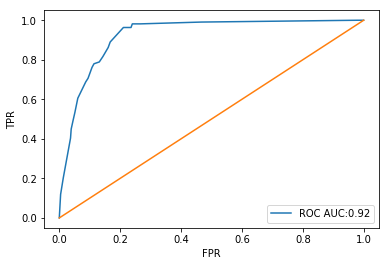

In [43]:
#ROC Curves for DT best model
#plotting ROC Curve
plt.plot(FPR,TPR,label=f"ROC AUC:{roc_auc_score(Y1,dt_grid.predict_proba(X1)[:,1]).round(2)}")
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

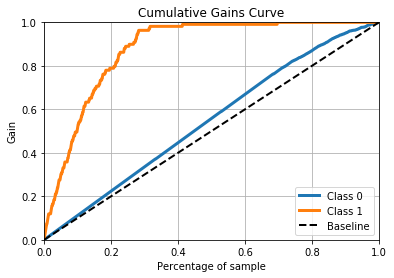

In [44]:
#Cummulative gain curve
skplt.metrics.plot_cumulative_gain(Y1,dt_grid.predict_proba(X1))
plt.show()

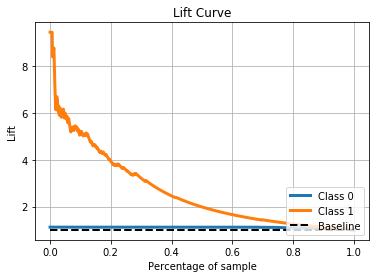

In [45]:
#lift curve
skplt.metrics.plot_lift_curve(Y1,dt_grid.predict_proba(X1))
plt.show()